# Optimization Methods for Data Science

##### Authors: Mojtaba Amini , Kamile Dementaviciute, Saeed Soufeh

##### HW1
##### Deadline: 04/11/2022

In the first part, the random data has been generated.

In [483]:
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from matplotlib import pyplot
from pandas import DataFrame
from time import process_time
import pandas as pd
from sklearn.utils import fixes
from sklearn.metrics.pairwise import euclidean_distances

Original size of X= 300	Unlabeled size = 294	labeled size = 6
Original size of y= 300	Unlabeled size = 294	labeled size = 6


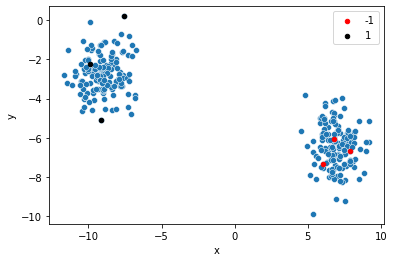

In [484]:
# generate 2d classification dataset
np.random.seed(15)
X, y = make_blobs(n_samples=300, centers=2, n_features=2)
x_Unlabeled ,x_labeled_bar,y1,y_label = train_test_split(X,y,test_size=0.02)

print(f"Original size of X= {X.shape[0]}\tUnlabeled size = {x_Unlabeled.shape[0]}\tlabeled size = {x_labeled_bar.shape[0]}")
print(f"Original size of y= {y.shape[0]}\tUnlabeled size = {y1.shape[0]}\tlabeled size = {y_label.shape[0]}")

y_label=y_label*2-1
df = DataFrame(dict(x=x_labeled_bar[:,0], y=x_labeled_bar[:,1], label=y_label))
colors = {-1:'red', 1:'black'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
sns.scatterplot(ax=ax,x=X[:,0],y=X[:,1])
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()



### <mark><b>Similarity Measure function</b></mark>

<ol>
  <li><b>Euclidean Distance</b></li>
  At first, for similarity, the similarity measure function has been defined as below:
  $$ d(x,y) = {e^{\sum_{i=1}^k (x_i-y_i)^2 }}$$

  So the similarity matrix is defined as below:

  $$\omega_{ij}={e^{(x_{1i}-x_{1j})^2+(x_{2i}-x_{2j})^2}}$$

  ${x_1}$ refer to the first dimension and ${x_2}$ is the second dimension in 2D.

  ${i ,j}$ are two indexes for labeled and unlabeled data. 

  Therefore the matrix is as below:

  $$
\omega_{ij}= \begin{bmatrix}
{e^{(x_{11}-x_{11})^2+(x_{21}-x_{21})^2}} & {e^{(x_{11}-x_{12})^2+(x_{21}-x_{22})^2}} & \cdots \\
{e^{(x_{12}-x_{11})^2+(x_{22}-x_{21})^2}} & \ddots & \cdots \\
\vdots & \cdots & \cdots \\
\end{bmatrix}
$$
</ol>

<b>Defining Similarity functions</b>

<b> Initializing matrixes</b>

In [485]:
def initialize_parameters(x_Unlabeled):
  np.random.seed(4)
# initialize the parameters with non-zeros numbers between(0,1)
  y_unlabel=np.random.rand(len(x_Unlabeled))*0.01
  return y_unlabel

<b>Defining the similarity matrix</b>

In [486]:
def similarity(x_Unlabeled,x_labeled_bar,type):
  wij=np.zeros((len(x_labeled_bar),len(x_Unlabeled)))
  wij_bar=np.zeros((len(x_Unlabeled),len(x_Unlabeled)))

  if type=="Gaussian" :
    wij = np.exp(- euclidean_distances(x_labeled_bar,x_Unlabeled))
    wij_bar = np.exp(-euclidean_distances(x_Unlabeled,x_Unlabeled))

  return wij,wij_bar


wij,wij_bar = similarity(x_Unlabeled,x_labeled_bar,"Gaussian")
print(wij.shape[0], wij.shape[1])  

6 294


### <mark><b>Cost function and it's derivative</b></mark>


 Cost function:
  $$ \min_{y\in{R^u}} \sum_{i=1}^l\sum_{j=1}^u \omega_{ij}(y^{j}-\bar{y}^{i})^2 + \frac{1}{2} \sum_{i=1}^u\sum_{j=1}^u \bar{\omega}_{ij}(y^{j}-y^{i})^2 $$

Gradient with respect to $y^{j}$:
$$\nabla_{y^{j}} f(y)=2\sum_{i=1}^l \omega_{ij}(y^{j}-\bar{y}^{i})+2 \sum_{i=1}^u \bar{\omega}_{ij}(y^{j}-y^{i})$$

$u$ : unlabeled data

$l$ : labeled data

$y$ : predicted label ( parameters)

$\bar{y}$ : determined label

$\omega_{ij}$ : similarity measure matrix between labeled and unlabeled data

$\bar{\omega}_{ij}$ : similarity measure matrix between unlabeled data


In [487]:
def cost_function(wij,wij_bar,y_unlabel,y_label):
  cost=0.0

  y_label_matrix = np.tile(y_label,(y_unlabel.shape[0],1))
  y_unlabel_array = np.reshape(y_unlabel,(y_unlabel.shape[0],1))
  wij_reshaped = wij.T
  sub1 = np.power(y_label_matrix-y_unlabel_array,2)
  mat1 = wij_reshaped*sub1
  term1 = np.sum(mat1)

  y_unlabel_matrix = np.tile(y_unlabel,(y_unlabel.shape[0],1))
  y_unlabel_array = np.reshape(y_unlabel,(y_unlabel.shape[0],1))
  wij_bar_reshaped = wij_bar.T
  sub2 = np.power(y_unlabel_matrix-y_unlabel_array,2)
  mat2 = wij_bar_reshaped*sub2
  term2 = np.sum(mat2)

  cost = term1 + 0.5*term2
  return cost

In [488]:
def dev_function(wij,wij_bar,y_unlabel,y_label,method,index=1,size=0):

  if method == "GD":
    size = y_unlabel.shape[0]

  dev = np.zeros(size)

  for j in range(size):
    term1=0.0
    term2=0.0
    
    for i in range(len(y_label)):
      term1 = term1 + wij[i,size*(index-1)+j] * (y_unlabel[size*(index-1)+j] - y_label[i])

    for i in range(len(y_unlabel)):
      term2 = term2 + wij_bar[i,size*(index-1)+j]*(y_unlabel[size*(index-1)+j]-y_unlabel[i])
    dev[j] = 2*(term1 + term2)

  return dev  

In [489]:
def dev_function(wij,wij_bar,y_unlabel,y_label,method,index=1,size=0):

  if method == "GD":

    y_label_matrix = np.tile(y_label,(y_unlabel.shape[0],1))
    y_unlabel_array = np.reshape(y_unlabel,(y_unlabel.shape[0],1))
    wij_reshaped = wij.T
    sub1 = y_label_matrix - y_unlabel_array
    mat1 = wij_reshaped * sub1
    term1 = np.sum(mat1,axis=1)

    y_unlabel_matrix = np.tile(y_unlabel,(y_unlabel.shape[0],1))
    y_unlabel_array = np.reshape(y_unlabel,(y_unlabel.shape[0],1))
    wij_bar_reshaped = wij_bar.T
    sub2 = y_unlabel_matrix - y_unlabel_array
    mat2 = wij_bar_reshaped * sub2
    term2 = np.sum(mat2, axis=1)

    dev = -2 *(term1 + term2)


  if method == "BCGD":

    y_label_matrix = np.tile(y_label ,(y_unlabel.shape[0],1))[index-1: index-1+ size] 
    y_unlabel_array = np.tile(y_unlabel[index-1: index-1 + size][0] ,(y_label.shape[0],1)).T 
    wij_reshaped = wij.T[index-1: index-1+ size]
    sub1 =  y_unlabel_array - y_label_matrix 
    mat1 = wij_reshaped * sub1
    term1 = np.sum(mat1)

    y_unlabel_matrix = np.tile(y_unlabel,(y_unlabel.shape[0],1))[index-1: index-1+ size]
    y_unlabel_array = y_unlabel[index-1: index-1+ size] 
    wij_bar_reshaped = wij_bar[index-1: index-1+ size]
    sub2 =  y_unlabel_array - y_unlabel_matrix
    mat2 = wij_bar_reshaped * sub2
    term2 = np.sum(mat2)

    dev = 2 *(term1 + term2)
  

  return dev  

### <mark><b>Gradient Descent</b></mark>


In [490]:
alpha=0.003
num_iterations=300
time_tracking_GD = np.zeros(num_iterations)

y_unlabel = initialize_parameters(x_Unlabeled)
wij,wij_bar = similarity(x_Unlabeled,x_labeled_bar,"Gaussian")
cost_func_GD = np.zeros(num_iterations)

t_start = process_time() 

for i in range(num_iterations): 
  derivative = dev_function(wij,wij_bar,y_unlabel,y_label,method = "GD")
  y_unlabel = y_unlabel-alpha*derivative
  cost_func_GD[i] = cost_function(wij,wij_bar,y_unlabel,y_label)
  time_tracking_GD[i] = process_time() - t_start

t_stop = process_time()

Gradient Descend
CPU time: 0.8951479580000523


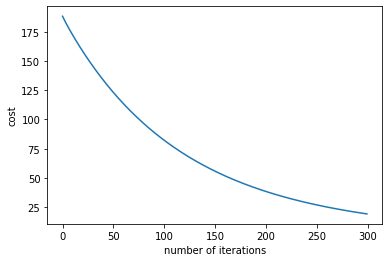

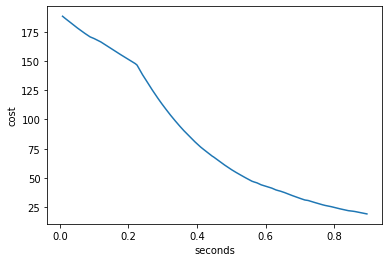

In [491]:
time_GD = t_stop - t_start

print("Gradient Descend")
print("CPU time:", time_GD)

sns.lineplot(x= range(num_iterations),y=cost_func_GD)
plt.xlabel("number of iterations")
plt.ylabel("cost")
plt.show()

sns.lineplot(x= time_tracking_GD,y=cost_func_GD)
plt.xlabel("seconds")
plt.ylabel("cost")
plt.show()

Visualizing the result to see that the assignment is correct or not!

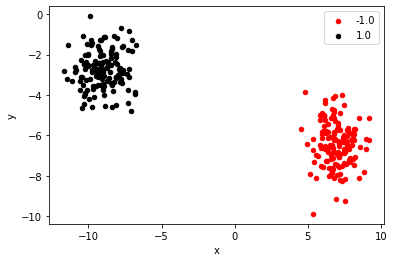

In [492]:
y_unlabel2=np.round((y_unlabel+1)/2)*2-1
df = DataFrame(dict(x=x_Unlabeled[:,0], y=x_Unlabeled[:,1], label=y_unlabel2))
colors = {-1:'red', 1:'black'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
# sns.scatterplot(ax=ax,x=x_labeled_bar[:,0],y=x_labeled_bar[:,1])

for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()

### <mark><b>Randomized Block Coordinate Gradient Decent</b></mark>

Since we want to be faster, we just want to calculate a part of derivative. Therefore, we change the derivative function for randomized and cyclic. methods.

In [493]:
alpha=0.003
time_tracking_RBCGD = np.zeros(num_iterations)

y_unlabel=initialize_parameters(x_Unlabeled)
wij,wij_bar=similarity(x_Unlabeled,x_labeled_bar,"Gaussian")
cost_func_RBCGD = np.zeros(num_iterations)

Block_size = 1
Num_Block = int(y_unlabel.shape[0]/Block_size)

In [494]:
t_start = process_time() 

for i in range(num_iterations):
  for b in range(Num_Block):
    Block_index = np.random.randint(1,Num_Block+1)
    derivative = dev_function(wij,wij_bar,y_unlabel,y_label,method = "BCGD",index = Block_index,size = Block_size)
    y_unlabel[Block_size*(Block_index-1):Block_size*(Block_index)] = y_unlabel[Block_size*(Block_index-1):Block_size*(Block_index)] \
    -alpha*derivative

  cost_func_RBCGD[i] = cost_function(wij,wij_bar,y_unlabel,y_label)
  time_tracking_RBCGD[i]  =  process_time() - t_start

t_stop = process_time()

Randomized BCGD
CPU time: 23.044239138999956


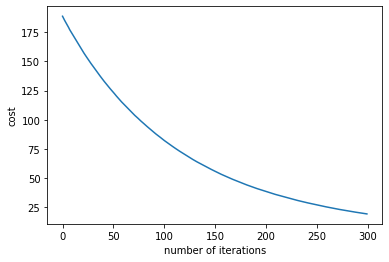

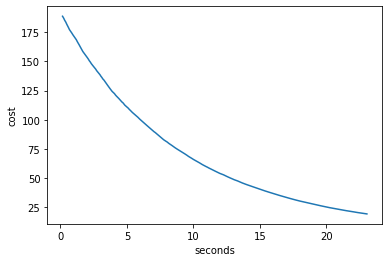

In [495]:
time_RBCGD = t_stop - t_start
print("Randomized BCGD")
print("CPU time:", time_RBCGD)

sns.lineplot(x = range(num_iterations),y = cost_func_RBCGD)
plt.xlabel("number of iterations")
plt.ylabel("cost")
plt.show()

sns.lineplot(x = time_tracking_RBCGD, y = cost_func_RBCGD)
plt.xlabel("seconds")
plt.ylabel("cost")
plt.show()

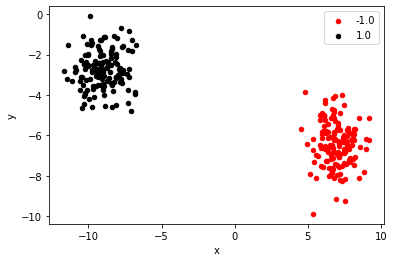

In [496]:
y_unlabel3=np.round((y_unlabel+1)/2)*2-1
df = DataFrame(dict(x=x_Unlabeled[:,0], y=x_Unlabeled[:,1], label=y_unlabel3))
colors = {-1:'red', 1:'black'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
#sns.scatterplot(ax=ax,x=x_labeled_bar[:,0],y=x_labeled_bar[:,1])

for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()

### <mark><b>Cyclic Block Coordinate Gradient Decent</b></mark>

In [497]:
alpha=0.003
time_tracking_CBCGD = np.zeros(num_iterations) 

y_unlabel=initialize_parameters(x_Unlabeled)
wij,wij_bar=similarity(x_Unlabeled,x_labeled_bar,"Gaussian")
cost_func_CBCGD = np.zeros(num_iterations)

Block_size=1
Num_Block=int(y_unlabel.shape[0]/Block_size)

In [498]:
t_start = process_time()

for i in range(num_iterations):
  for Block_index in range(1,Num_Block+1):
    derivative = dev_function(wij,wij_bar,y_unlabel,y_label,method = "BCGD",index = Block_index,size = Block_size)
    y_unlabel[Block_size*(Block_index-1):Block_size*(Block_index)] = y_unlabel[Block_size*(Block_index-1):Block_size*(Block_index)] \
    -alpha*derivative

  cost_func_CBCGD[i] = cost_function(wij,wij_bar,y_unlabel,y_label)
  time_tracking_CBCGD[i]  =  process_time() - t_start

t_stop = process_time()

BCGD with Cyclic Rule
CPU time: 21.688401271999965


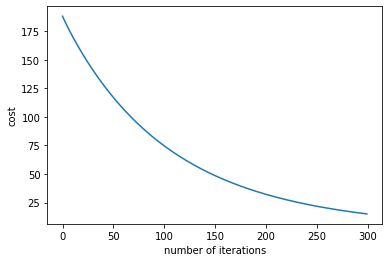

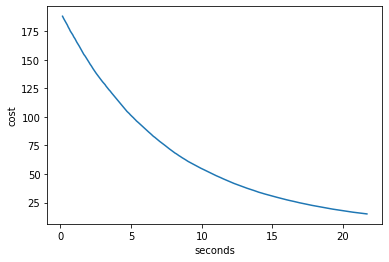

In [499]:
time_CBCGD = t_stop - t_start
print("BCGD with Cyclic Rule")
print("CPU time:", time_CBCGD)

sns.lineplot(x = range(num_iterations),y = cost_func_CBCGD)
plt.xlabel("number of iterations")
plt.ylabel("cost")
plt.show()

sns.lineplot(x = time_tracking_CBCGD, y = cost_func_CBCGD)
plt.xlabel("seconds")
plt.ylabel("cost")
plt.show()

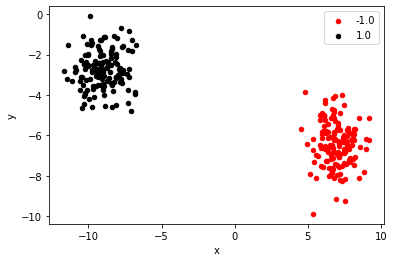

In [500]:
y_unlabel3=np.round((y_unlabel+1)/2)*2-1
df = DataFrame(dict(x=x_Unlabeled[:,0], y=x_Unlabeled[:,1], label=y_unlabel3))
colors = {-1:'red', 1:'black'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
#sns.scatterplot(ax=ax,x=x_labeled_bar[:,0],y=x_labeled_bar[:,1])
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()

## Comparison of all three methods

GD CPU time: 0.8951479580000523
RBCGD CPU time: 23.044239138999956
CBCGD CPU time: 21.688401271999965


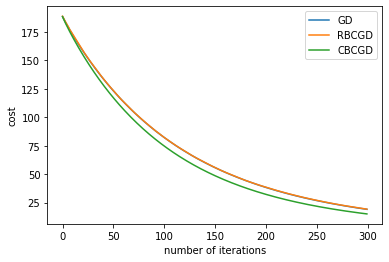

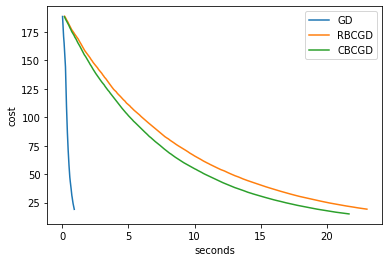

In [501]:
print("GD CPU time:", time_GD)
print("RBCGD CPU time:", time_RBCGD)
print("CBCGD CPU time:", time_CBCGD)


sns.lineplot(x= range(num_iterations),y=cost_func_GD, label='GD')
sns.lineplot(x = range(num_iterations),y = cost_func_RBCGD, label='RBCGD')
sns.lineplot(x = range(num_iterations),y = cost_func_CBCGD, label='CBCGD')
plt.xlabel("number of iterations")
plt.ylabel("cost")
plt.show()

sns.lineplot(x= time_tracking_GD,y=cost_func_GD, label='GD')
sns.lineplot(x = time_tracking_RBCGD, y = cost_func_RBCGD, label='RBCGD')
sns.lineplot(x = time_tracking_CBCGD, y = cost_func_CBCGD, label='CBCGD')
plt.xlabel("seconds")
plt.ylabel("cost")
plt.show()

## Testing the methods with an outsourced dataset

In [502]:
#import data from excel to python
df = pd.read_excel (r'/content/Pumpkin_Seeds_Dataset.xlsx',sheet_name='Pumpkin_Seeds_Dataset')
df.head()

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Convex_Area,Equiv_Diameter,Eccentricity,Solidity,Extent,Roundness,Aspect_Ration,Compactness,Class
0,56276,888.242,326.1485,220.2388,56831,267.6805,0.7376,0.9902,0.7453,0.8963,1.4809,0.8207,Çerçevelik
1,76631,1068.146,417.1932,234.2289,77280,312.3614,0.8275,0.9916,0.7151,0.8440,1.7811,0.7487,Çerçevelik
2,71623,1082.987,435.8328,211.0457,72663,301.9822,0.8749,0.9857,0.7400,0.7674,2.0651,0.6929,Çerçevelik
3,66458,992.051,381.5638,222.5322,67118,290.8899,0.8123,0.9902,0.7396,0.8486,1.7146,0.7624,Çerçevelik
4,66107,998.146,383.8883,220.4545,67117,290.1207,0.8187,0.9850,0.6752,0.8338,1.7413,0.7557,Çerçevelik


In [503]:
#turning categorical labels to numeric labels(-1 & 1)
data_classes = list(df.Class.unique())
d = dict(zip(data_classes, [-1,1]))
df['Class'] = df['Class'].map(d, na_action='ignore')
df.head()

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Convex_Area,Equiv_Diameter,Eccentricity,Solidity,Extent,Roundness,Aspect_Ration,Compactness,Class
0,56276,888.242,326.1485,220.2388,56831,267.6805,0.7376,0.9902,0.7453,0.8963,1.4809,0.8207,-1
1,76631,1068.146,417.1932,234.2289,77280,312.3614,0.8275,0.9916,0.7151,0.8440,1.7811,0.7487,-1
2,71623,1082.987,435.8328,211.0457,72663,301.9822,0.8749,0.9857,0.7400,0.7674,2.0651,0.6929,-1
3,66458,992.051,381.5638,222.5322,67118,290.8899,0.8123,0.9902,0.7396,0.8486,1.7146,0.7624,-1
4,66107,998.146,383.8883,220.4545,67117,290.1207,0.8187,0.9850,0.6752,0.8338,1.7413,0.7557,-1


In [504]:
#leave 2 percent of the data as labeled
index = list(np.random.randint(low=0, high=2500, size=int(df.shape[0]*0.02)))
df_labeled = df.iloc[index]

In [505]:
#make the rest of the data as unlabeled
index_unlabeled=list(set(range(df.shape[0]))-set(index))
df_unlabeled = df.iloc[index_unlabeled]
df_unlabeled.drop(columns = "Class", inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [506]:
print(df.shape)
print(df_labeled.shape)
print(df_unlabeled.shape)

(2500, 13)
(50, 13)
(2450, 12)


In [507]:
#change the names so we can use it with the main code
x_Unlabeled = df_unlabeled
x_labeled_bar = df_labeled.iloc[:,:-1]
y_label = df_labeled["Class"]

In [508]:
#change dataframes to numpy arrays
x_Unlabeled = df_unlabeled.to_numpy()
x_labeled_bar = df_labeled.iloc[:,:-1].to_numpy()
y_label = df_labeled["Class"].to_numpy()